In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf_yw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy.fftpack import fft


C:\Users\Justin\AppData\Local\Temp\ipykernel_4016\2156494890.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


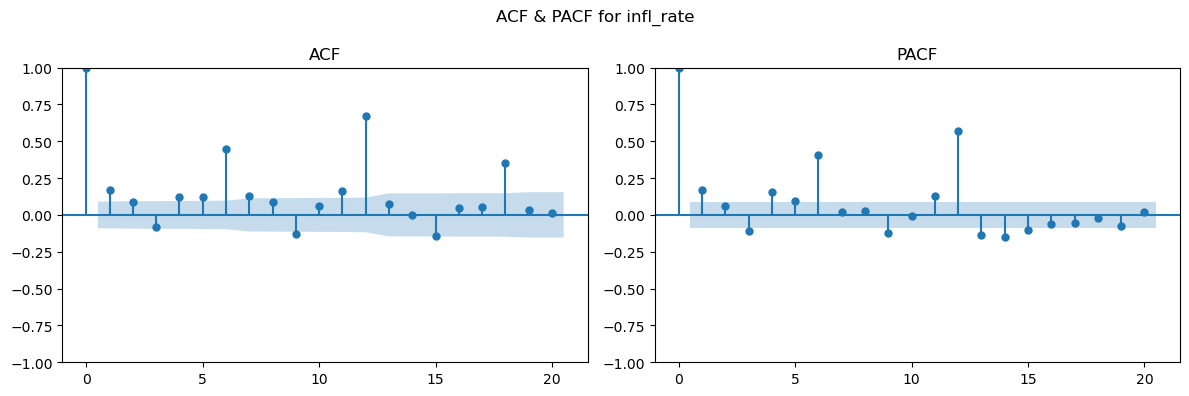

infl_rate: p-value = 0.02133416177384412


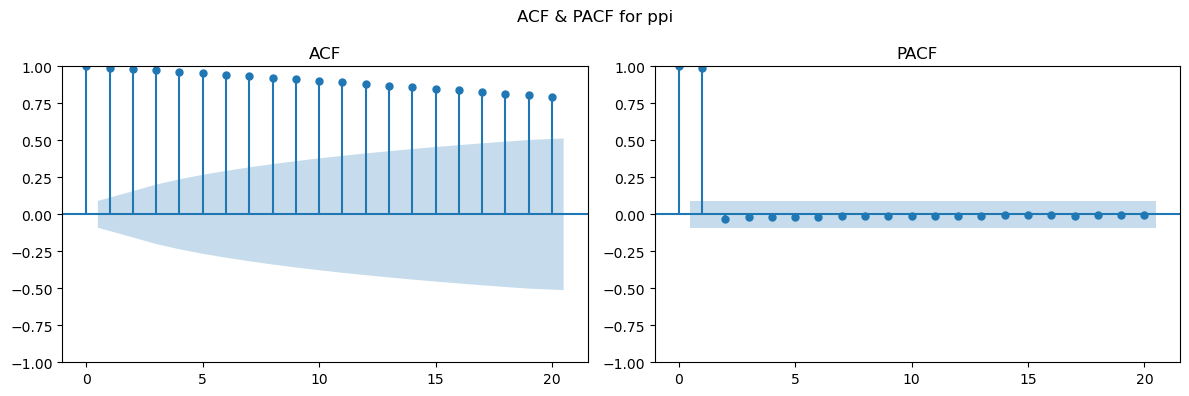

ppi: p-value = 0.978908346428475
Non-stationary ppi differenced for stationarity


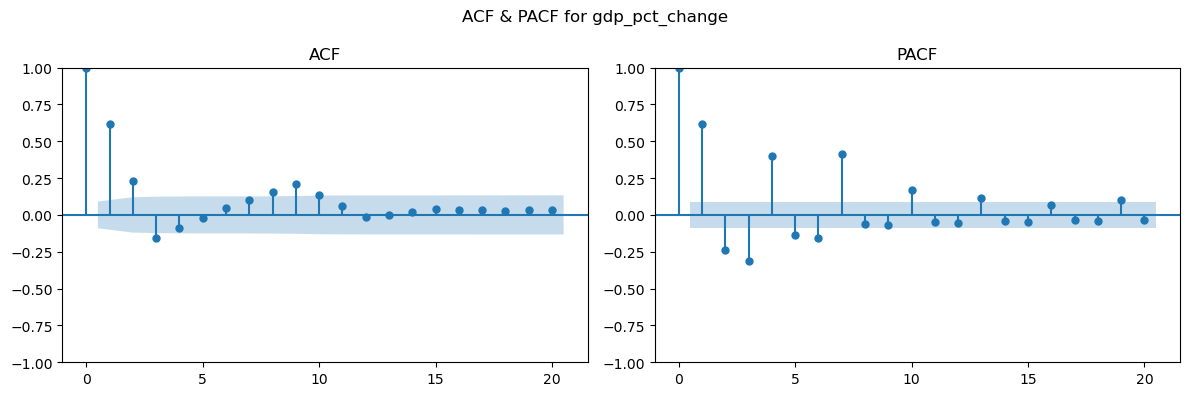

gdp_pct_change: p-value = 0.00039413535611770926


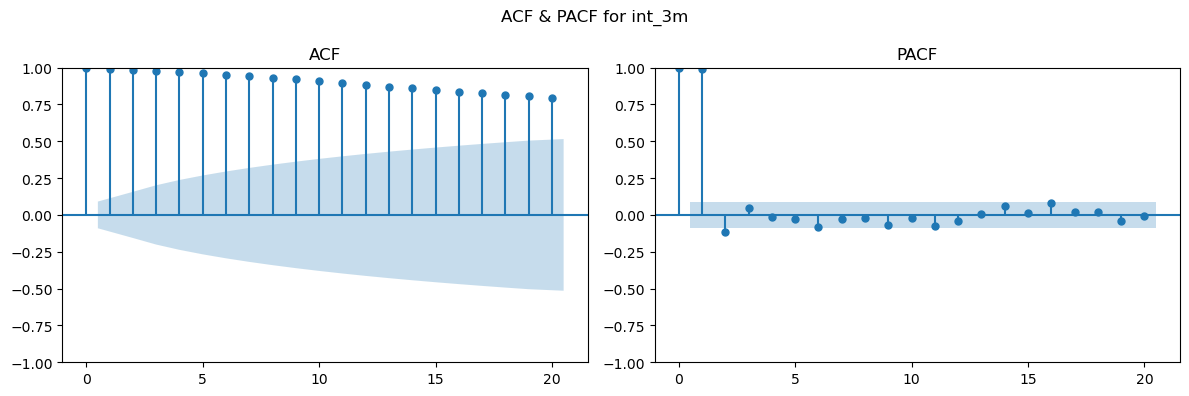

int_3m: p-value = 0.49733890398549624
Non-stationary int_3m differenced for stationarity


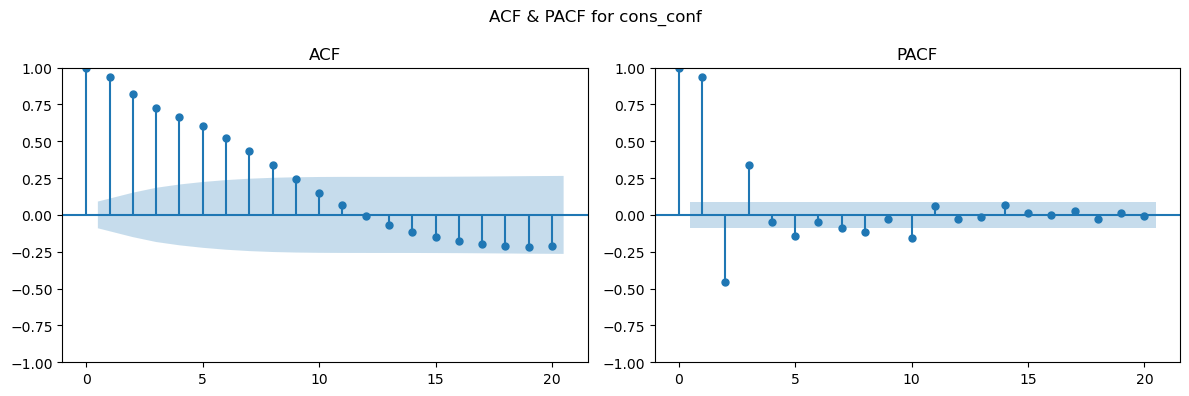

cons_conf: p-value = 1.6534059253850702e-08


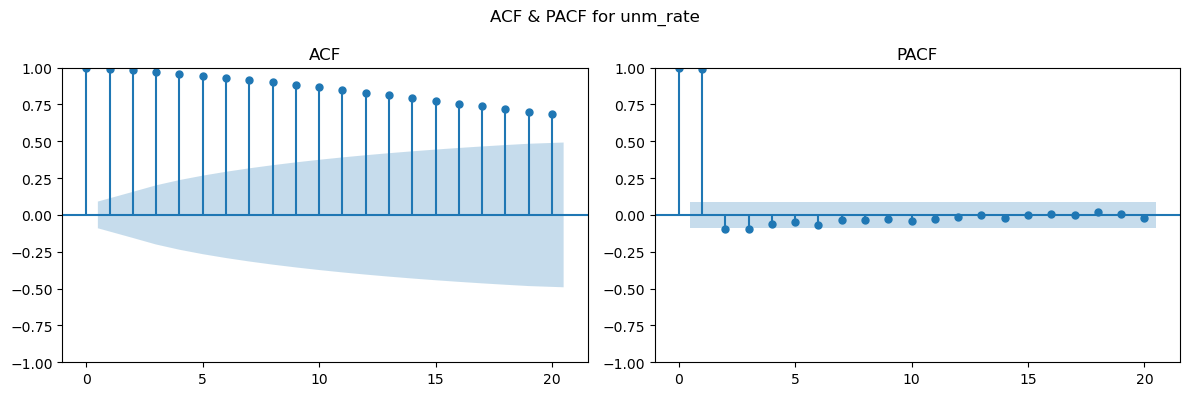

unm_rate: p-value = 0.07077782574137147
Non-stationary unm_rate differenced for stationarity
Variables that need differencing: ['ppi', 'int_3m', 'unm_rate']


In [2]:
def preprocess_data(df):
    """
    Clean and preprocess the DataFrame:
      - Convert 'date' column to datetime and set as index.
      - Interpolate missing values.
      - Identify outliers in CPI using the Z-score method.
      - Check stationarity of the series using the ADF test and plot the PACF.
      - Identify and visualize seasonal decomposition of each series.
      - Perform Ljung-Box test on residuals to check for any remaining autocorrelation.
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        df (DataFrame): Preprocessed DataFrame with new columns added.
    """
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    # Handle missing values using forward fill for simplicity in this example
    df.fillna(method='ffill', inplace=True)
    need_differencing = []

    # Plot PACF for each macroeconomic variable including CPI
    variables = ['infl_rate', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']
    for var in variables:
        if var in df.columns:
            # Create side-by-side subplots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f'ACF & PACF for {var}')

            # ACF plot
            plot_acf(df[var].dropna(), lags=20, ax=axes[0])
            axes[0].set_title('ACF')

            # PACF plot
            plot_pacf(df[var].dropna(), lags=20, method='ywm', ax=axes[1])
            axes[1].set_title('PACF')

            plt.tight_layout()
            plt.show()

            # Check for stationarity and differencing
            result = adfuller(df[var])
            print(f'{var}: p-value = {result[1]}')
            if result[1] > 0.05:  # if p-value > 0.05, series is not stationary
                need_differencing.append(var)
                df[f'{var}_diff'] = df[var].diff().dropna()
                print(f'Non-stationary {var} differenced for stationarity')
    # Print those that need differencing
    print(f"Variables that need differencing: {need_differencing}")

    return df

df = pd.read_csv('../data/UK_consolidated_df.csv')
df_preprocessed = preprocess_data(df)


In [3]:
df

,infl_rate,ppi,gdp_pct_change,int_3m,cons_conf,unm_rate,ppi_diff,int_3m_diff,unm_rate_diff
date,,,,,,,,,
1986-02-01,0.004158,51.456058,1.789575,12.71875,99.70575,11.1,NaN,NaN,NaN
1986-03-01,0.001035,51.456058,1.789575,11.77679,99.74067,11.2,0.000000,-0.94196,0.1
1986-04-01,0.010341,51.612699,1.219277,10.57670,99.80801,11.3,0.156641,-1.20009,0.1
1986-05-01,0.001024,51.377741,1.219277,10.26705,99.85727,11.3,-0.234958,-0.30965,0.0
1986-06-01,0.000000,51.456058,1.219277,9.82292,99.89935,11.3,0.078317,-0.44413,0.0
...,...,...,...,...,...,...,...,...,...
2024-08-01,0.003762,136.488626,1.364935,4.91000,101.52670,4.3,0.000000,-0.18000,0.2
2024-09-01,0.000750,136.488626,1.364935,4.84000,101.45370,4.3,0.000000,-0.07000,0.0
2024-10-01,0.005993,136.488626,1.064721,4.75000,101.33200,4.4,0.000000,-0.09000,0.1


EDA

Index(['date', 'infl_rate', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf',
       'unm_rate'],
      dtype='object')
int_3m
unm_rate


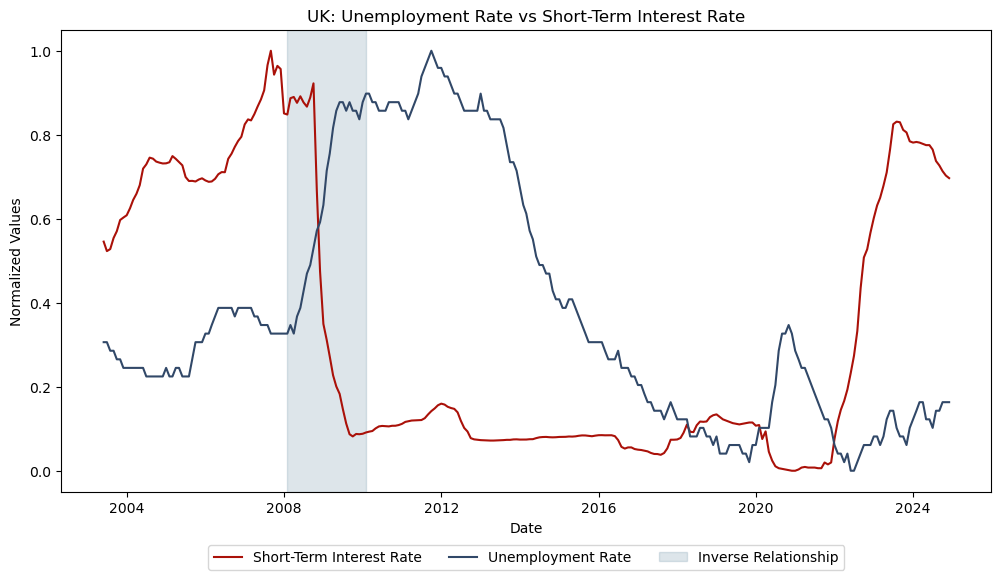

cons_conf
gdp_pct_change


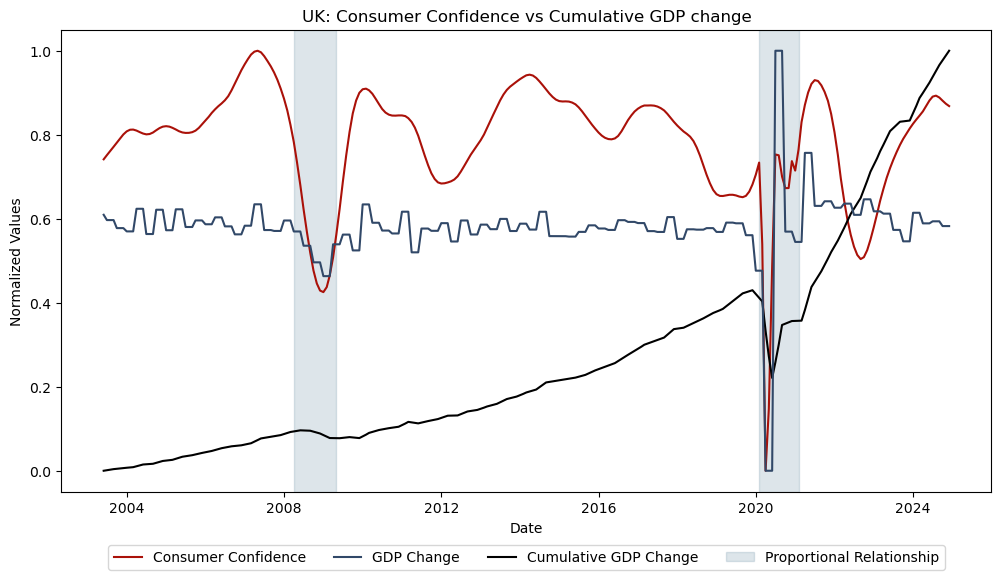

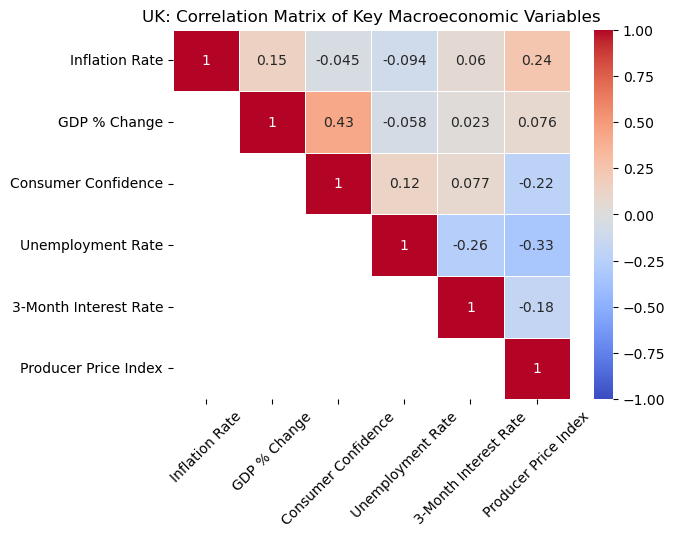

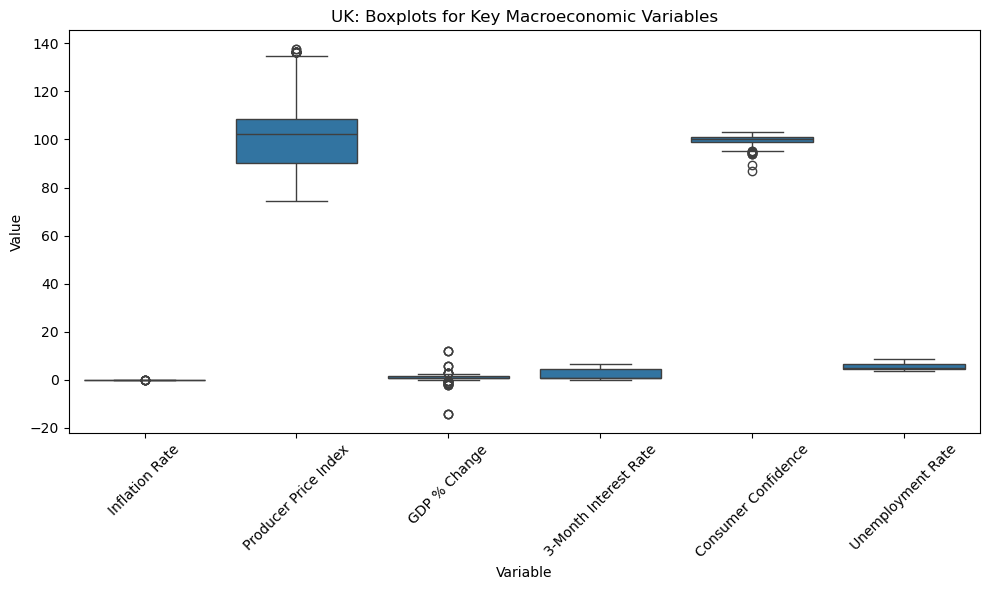

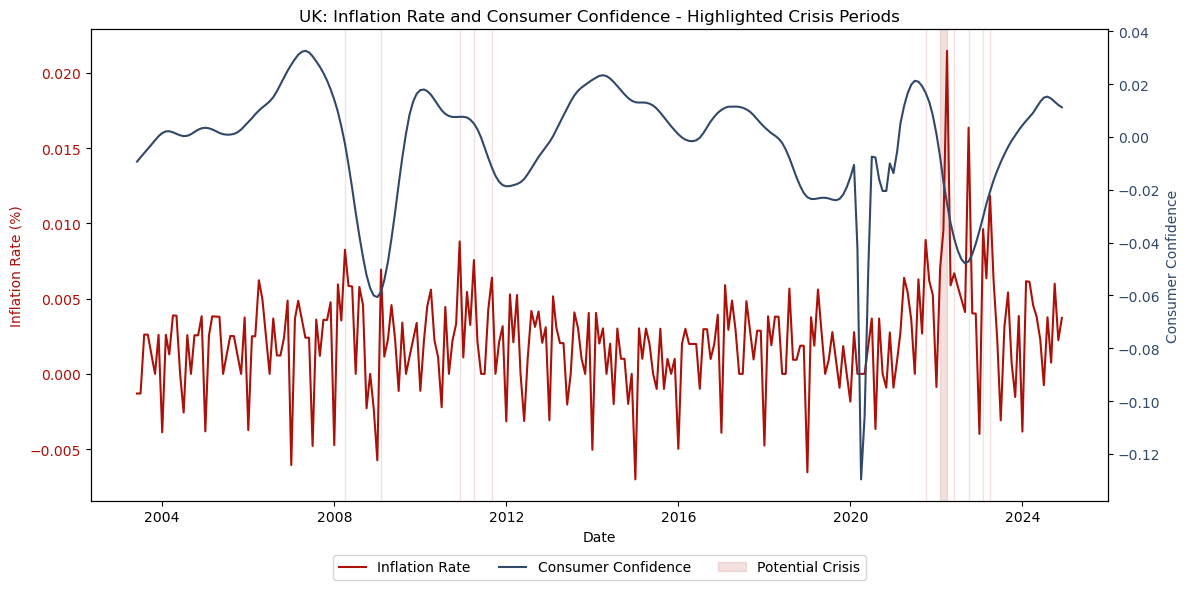

In [12]:
from scipy.cluster.hierarchy import linkage, leaves_list
from itertools import groupby
from operator import itemgetter
from matplotlib.gridspec import GridSpec
import numpy as np

palette = ['#314868', '#597aa8', '#557f97', '#e7eae1', '#aa1109', '#c76968', '#ebcccd']

def exploratory_data_analysis(df):
    """
    Perform enhanced Exploratory Data Analysis (EDA):
    - Analyze inflation rate trends.
    - Check for correlation with other macroeconomic variables.
    - Identify and visualize major economic events.
    - Detect potential crises based on inflation rate spikes.
    - Perform FFT to identify cyclical patterns.
    - Compare inflation rates across different datasets/countries if applicable.
    """
    df['date'] = pd.to_datetime(df['date'])
    df_plot = df.reset_index()

    # 1. Plot time series (unemployment rate vs short term interest rate)
    import matplotlib.patches as mpatches
    highlight_patch = None

    first_plot_custom_labels = {
    'unm_rate': 'Unemployment Rate',
    'int_3m': 'Short-Term Interest Rate'
    }
    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())
    
    indicators = ['int_3m', 'unm_rate']
    plt.figure(figsize=(12, 6))
    for indicator in indicators:
        if indicator in df_plot.columns:
            if indicator == 'int_3m':
                color = palette[4]
            else:
                color = palette[0]
            print(indicator)
            normalized_series = min_max_scaling(df_plot[indicator])
            plt.plot(df_plot['date'], normalized_series, label=first_plot_custom_labels[indicator], color=color)
    # Highlight the two date ranges
    highlight_ranges = [
        ('2008-02-01', '2010-02-01')
    ]
    for start, end in highlight_ranges:
        highlight_patch = plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=palette[2], alpha=0.2)

    highlight_legend = mpatches.Patch(color=palette[2], alpha=0.2, label='Inverse Relationship')

    plt.title('UK: Unemployment Rate vs Short-Term Interest Rate')
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.legend(handles=[
    plt.Line2D([], [], color=palette[4], label='Short-Term Interest Rate'),
    plt.Line2D([], [], color=palette[0], label='Unemployment Rate'),
    highlight_legend],
    loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.show()

    # 2. Plot time series (consumer confidence vs cumulative GDP change)

    second_highlight_patch = None

    second_plot_custom_labels = {
    'cons_conf': 'Consumer Confidence',
    'gdp_pct_change': 'GDP Change'
    }
    indicators = ['cons_conf', 'gdp_pct_change']
    plt.figure(figsize=(12, 6))

    for indicator in indicators:
        if indicator in df_plot.columns:
            print(indicator)
            if indicator == 'cons_conf':
                color = palette[4]
            else:
                color = palette[0]
            if indicator == 'gdp_pct_change':
                # Convert percentage change to cumulative change
                cumulative_gdp = (1 + df_plot[indicator] / 100).cumprod()
                normalized_cumu_series = min_max_scaling(cumulative_gdp)
                plt.plot(df_plot['date'], normalized_cumu_series, label="Cumulative GDP Change", color='black')
            normalized_series = min_max_scaling(df_plot[indicator])
            plt.plot(df_plot['date'], normalized_series, label=second_plot_custom_labels[indicator], color=color)
    highlight_ranges = [
        ('2008-04-01', '2009-05-01'),
        ('2020-02-01', '2021-02-01')
    ]
    for start, end in highlight_ranges:
        second_highlight_patch = plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=palette[2], alpha=0.2)

    highlight_legend = mpatches.Patch(color=palette[2], alpha=0.2, label='Proportional Relationship')

    plt.title('UK: Consumer Confidence vs Cumulative GDP change')
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.legend(handles=[
    plt.Line2D([], [], color=palette[4], label='Consumer Confidence'),
    plt.Line2D([], [], color=palette[0], label='GDP Change'),
    plt.Line2D([], [], color='black', label='Cumulative GDP Change'),
    highlight_legend],
    loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    plt.show()


    # 3. Correlation heatmap for key macroeconomic variables

    from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

    low_color = palette[0]  # light
    mid_color = palette[3]  
    high_color  = palette[4]  # dark
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [low_color, mid_color, high_color])
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

    third_and_fourth_plot_custom_labels = {
    'infl_rate': 'Inflation Rate',
    'ppi': 'Producer Price Index',
    'gdp_pct_change': 'GDP % Change',
    'int_3m': '3-Month Interest Rate',
    'cons_conf': 'Consumer Confidence',
    'unm_rate': 'Unemployment Rate'
    }

    manual_order = ['infl_rate','gdp_pct_change','cons_conf', 'unm_rate', 'int_3m',  'ppi']

    key_variables = list(third_and_fourth_plot_custom_labels.keys())
    corr_matrix = df[key_variables].corr()
    sorted_corr = corr_matrix.loc[manual_order, manual_order]
    sorted_corr.rename(index=third_and_fourth_plot_custom_labels, columns=third_and_fourth_plot_custom_labels, inplace=True)
    mask = np.tril(np.ones_like(sorted_corr, dtype=bool), k=-1)
    sns.heatmap(sorted_corr, annot=True, cmap="coolwarm", mask=mask, linewidths=.5, norm=norm) #cmap=custom_cmap,
    plt.xticks(rotation=45)
    plt.title('UK: Correlation Matrix of Key Macroeconomic Variables')
    plt.show()

    # 4. Boxplot for Outlier Detection
    # Melt the DataFrame into long format
    df_melted = df[key_variables].melt(var_name='Variable', value_name='Value')
    df_melted['Variable'] = df_melted['Variable'].map(third_and_fourth_plot_custom_labels)

    # Create vertical boxplots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted) #, palette=palette
    plt.title('UK: Boxplots for Key Macroeconomic Variables')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5. Crisis Detection - High Inflation Periods
    # Identify high inflation threshold and spans
    crisis_threshold = df['infl_rate'].quantile(0.95)
    df['High Inflation'] = df['infl_rate'] > crisis_threshold

    # Group consecutive high inflation periods
    high_inflation_indices = df[df['High Inflation']].index.tolist()
    groups = []
    for k, g in groupby(enumerate(high_inflation_indices), lambda ix: ix[0] - ix[1]):
        group = list(map(itemgetter(1), g))
        groups.append((df['date'].iloc[group[0]], df['date'].iloc[group[-1]]))

    # Plot with twin y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot inflation rate
    ax1.plot(df['date'], df['infl_rate'], label='Inflation Rate', color=palette[4])
    for start_date, end_date in groups:
        ax1.axvspan(start_date, end_date, color=palette[5], alpha=0.2)

    ax1.set_ylabel('Inflation Rate (%)', color=palette[4])
    ax1.tick_params(axis='y', labelcolor=palette[4])

    # Twin y-axis for consumer confidence
    ax2 = ax1.twinx()
    ax2.plot(df['date'], (df_plot['cons_conf']/100)-1, label='Consumer Confidence', color=palette[0])
    ax2.set_ylabel('Consumer Confidence', color=palette[0])
    ax2.tick_params(axis='y', labelcolor=palette[0])

    # Title and grid
    plt.title('UK: Inflation Rate and Consumer Confidence - Highlighted Crisis Periods')
    ax1.set_xlabel('Date')

    # Legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    highlight_patch = mpatches.Patch(color=palette[5], alpha=0.2, label='High Inflation Period')
    ax1.legend(lines_1 + lines_2 + [highlight_patch], labels_1 + labels_2 + ['Potential Crisis'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    plt.tight_layout()
    plt.show()



    return df

df = pd.read_csv('../data/UK_consolidated_df.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > '2003-05-01'].reset_index(drop=True)
print(df.columns)  # This line will print the DataFrame columns for debugging
eda_results = exploratory_data_analysis(df)

## Do you observe any interesting patterns or relationships (with other macroeconomic time
series that you culled) from your data?

In [5]:
def plot_inflation_time_series_relationships(df):
    """
    Plots inflation time series alongside each macroeconomic variable for comparison.
    Each variable is normalized for visual clarity.
    """
    import matplotlib.pyplot as plt

    features_to_compare = ['gdp_pct_change', 'cons_conf', 'unm_rate', 'int_3m', 'ppi']
    inflation_col = 'infl_rate'

    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())

    for feature in features_to_compare:
        if feature in df.columns:
            fig, ax = plt.subplots(figsize=(12, 5))
            
            # Normalize both series for better visual comparison
            infl_norm = min_max_scaling(df[inflation_col])
            feat_norm = min_max_scaling(df[feature])

            ax.plot(df['date'], infl_norm, label='Inflation Rate (normalized)', color=palette[4])
            ax.plot(df['date'], feat_norm, label=f'{feature} (normalized)', color=palette[0])
            
            ax.set_title(f"Time Series Comparison: Inflation vs {feature}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Normalized Values")
            ax.legend()
            plt.tight_layout()
            plt.show()


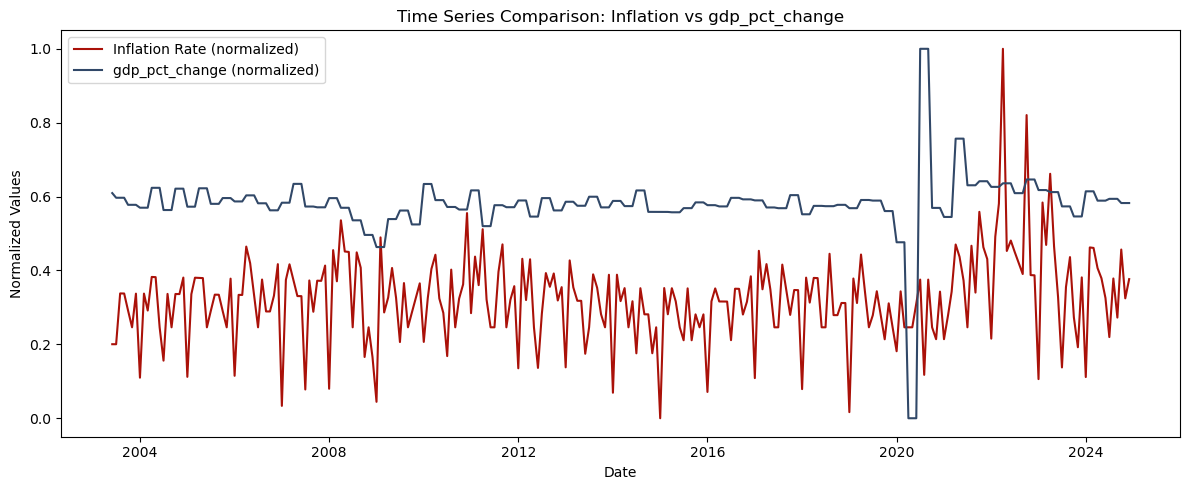

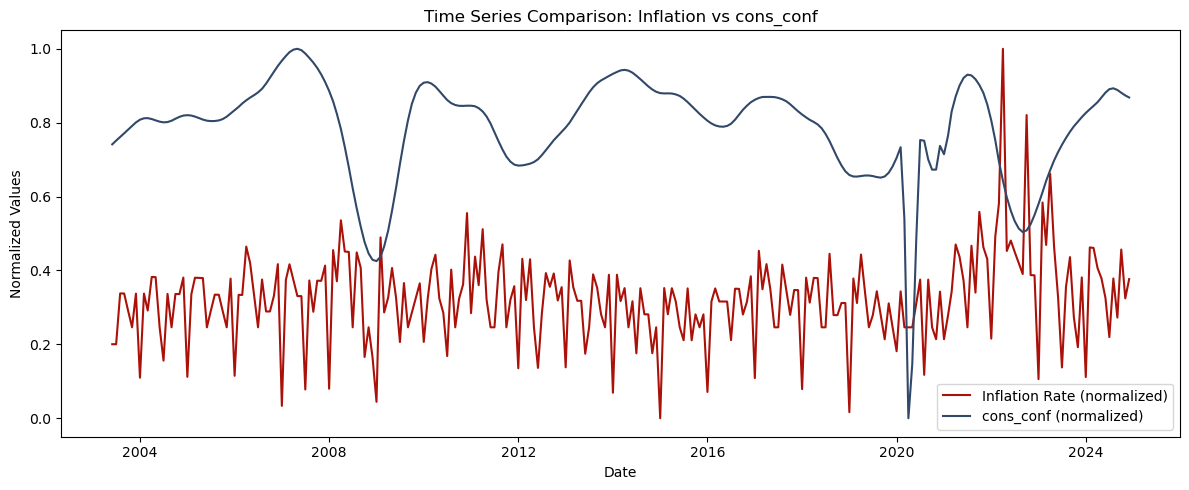

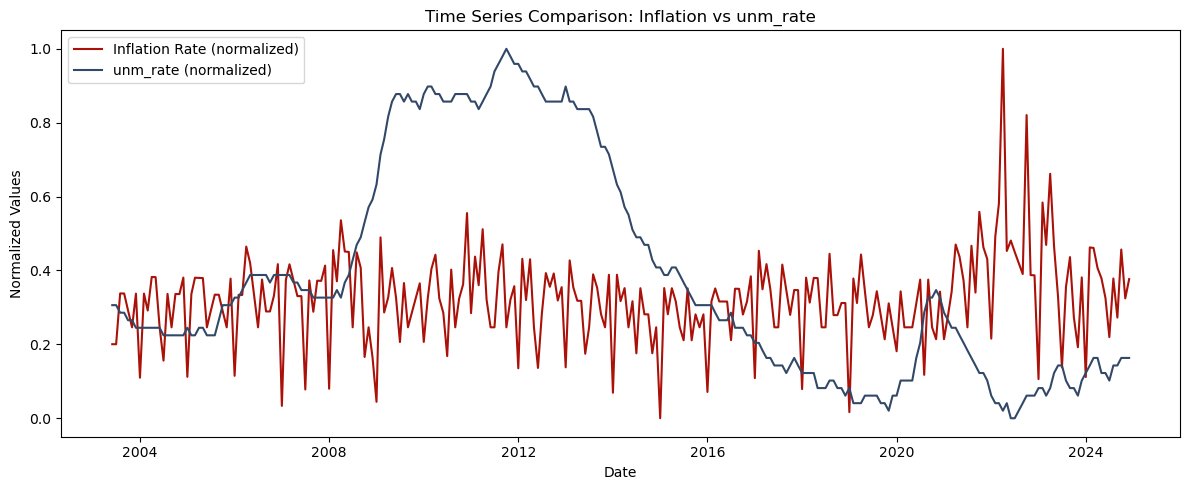

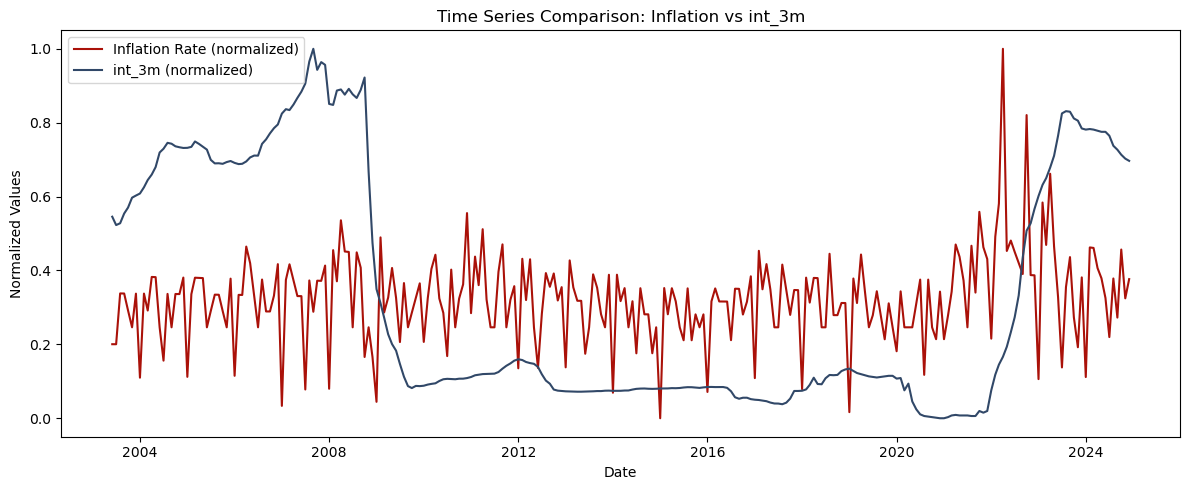

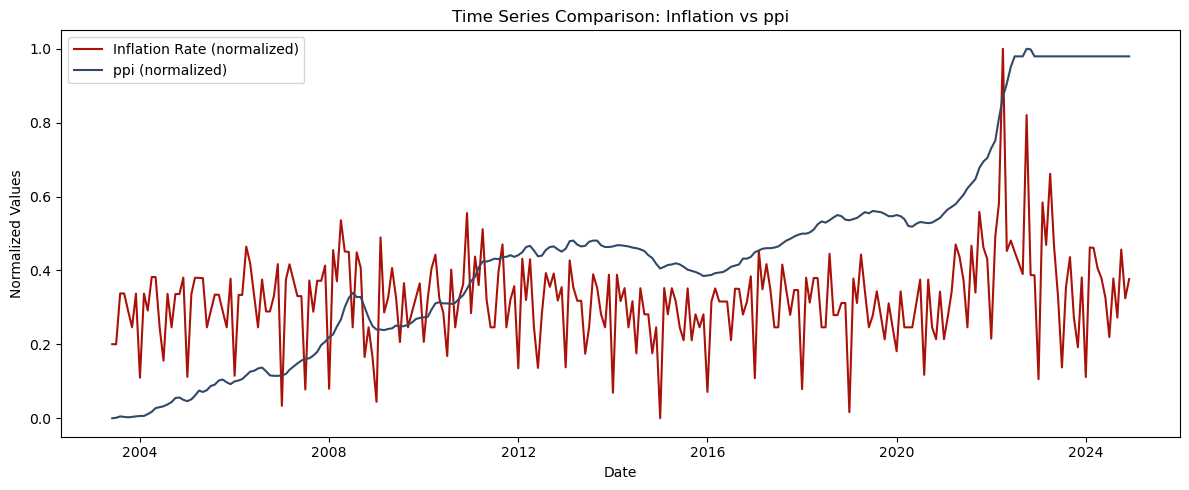

In [6]:
plot_inflation_time_series_relationships(df)


Yes — based on the time series comparisons between inflation and other macroeconomic variables, here are the key insights for each plot:

🧠 1. Inflation vs GDP % Change
Visual Insight: Inflation (red) fluctuates a lot, while GDP growth (blue) stays relatively flat except for a major dip and spike during the COVID-19 period (2020).

Conclusion: There's little visible co-movement, and GDP appears to react more to crises than to inflation trends.

🔍 Insight: Inflation and GDP don't track closely over time — they likely respond to different macro shocks.

🧠 2. Inflation vs Consumer Confidence
Visual Insight: Consumer confidence rises and falls in smooth waves, while inflation is choppier. There is a dip in confidence around 2008 and 2020, corresponding to financial and COVID crises.

Conclusion: No strong inverse relationship is visible, though both drop during crises.

🔍 Insight: Consumer confidence likely reacts to economic downturns rather than driving inflation directly.

🧠 3. Inflation vs Unemployment Rate
Visual Insight: A visible inverse pattern exists during some periods — e.g., from 2009–2012, high unemployment and low inflation; in 2021–2022, low unemployment and higher inflation.

Conclusion: This is somewhat in line with the Phillips Curve, but the relationship is not consistent throughout.

🔍 Insight: Inflation and unemployment show cyclical inverse behavior at times, but it’s not stable across all years.

🧠 4. Inflation vs PPI (Producer Price Index)
Visual Insight: PPI rises steadily from 2003–2023. There’s a noticeable sharp rise in both PPI and inflation around 2021.

Conclusion: PPI and inflation move in tandem, especially during post-pandemic inflation surges.

🔍 Insight: PPI is the most consistent leading indicator for inflation — as producer costs rise, they seem to be passed to consumers.

🧠 5. Inflation vs Short-Term Interest Rate (3M)
Visual Insight: In the 2008 crisis and 2020 COVID dip, interest rates dropped sharply, while inflation remained volatile. Around 2022, both increased.

Conclusion: The timing doesn't consistently align; interest rate changes lag behind inflation, as they’re used reactively by policymakers.

🔍 Insight: Short-term interest rates reflect central bank responses to inflation, but don't lead it.

📌 Final Summary:
Variable	Time Series Co-Movement with Inflation	Notable Insights
GDP % Change	Low	GDP swings mainly in crisis years; weak alignment with inflation
Consumer Conf	Low–moderate	Falls in confidence during crises align loosely with inflation dips
Unemployment	Moderate (inverse, inconsistent)	Shows occasional inverse patterns — weak Phillips Curve signal
PPI	Strong (positive)	Tracks inflation closely; useful leading indicator
Interest Rate	Weak–moderate (lagged)	Rates respond to inflation but don’t predict it

## How do inflation rates correlate with business cycle phrases, particularly during recession
periods? (Be mindful of how ‘recessions’ are defined in each country.)

In [7]:
df = pd.read_csv('../data/UK_consolidated_df.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns

Index(['date', 'infl_rate', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf',
       'unm_rate'],
      dtype='object')

Average Inflation during Recession:       0.32%
Average Inflation during Near-Recession: 0.11%
Average Inflation during Normal Periods: 0.24%


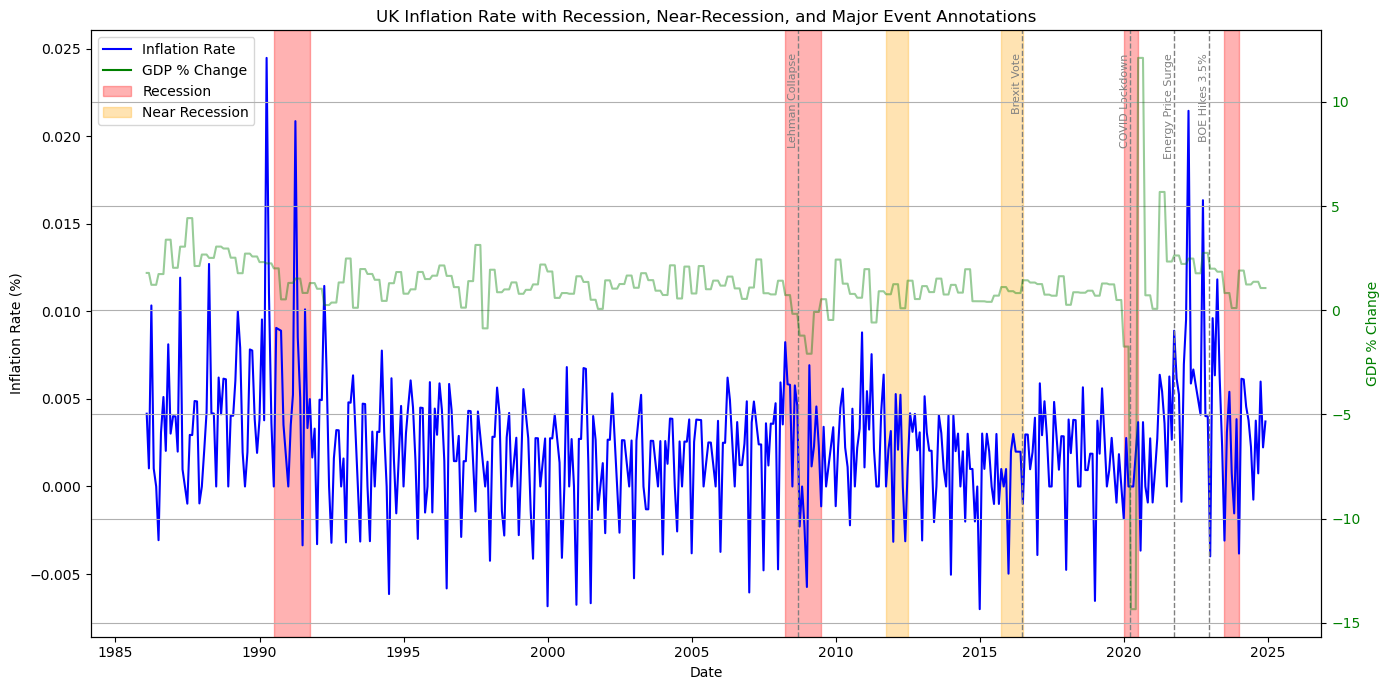

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Define recession and near-recession periods
recession_periods = [
    (pd.to_datetime('1990-07-01'), pd.to_datetime('1991-09-30')),
    (pd.to_datetime('2008-04-01'), pd.to_datetime('2009-06-30')),
    (pd.to_datetime('2020-01-01'), pd.to_datetime('2020-06-30')),
    (pd.to_datetime('2023-07-01'), pd.to_datetime('2023-12-31'))
]

near_recession_periods = [
    (pd.to_datetime('2011-10-01'), pd.to_datetime('2012-06-30')),
    (pd.to_datetime('2015-10-01'), pd.to_datetime('2016-06-30'))
]

# Create mask columns
df['is_recession'] = False
df['is_near_recession'] = False
for start, end in recession_periods:
    df.loc[df['date'].between(start, end), 'is_recession'] = True
for start, end in near_recession_periods:
    df.loc[df['date'].between(start, end), 'is_near_recession'] = True

# Calculate averages
avg_recession = df[df['is_recession']]['infl_rate'].mean()
avg_near_recession = df[df['is_near_recession']]['infl_rate'].mean()
avg_non_recession = df[(~df['is_recession']) & (~df['is_near_recession'])]['infl_rate'].mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(df['date'], df['infl_rate'], label='Inflation Rate', color='blue')

# Highlight shaded periods
for start, end in recession_periods:
    ax1.axvspan(start, end, color='red', alpha=0.3)
for start, end in near_recession_periods:
    ax1.axvspan(start, end, color='orange', alpha=0.3)

# Add GDP % Change on secondary Y-axis (optional)
if 'gdp_pct_change' in df.columns:
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['gdp_pct_change'], label='GDP % Change', color='green', alpha=0.4)
    ax2.set_ylabel('GDP % Change', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

# Annotations
event_annotations = [
    ('2008-09-15', 'Lehman Collapse'),
    ('2016-06-23', 'Brexit Vote'),
    ('2020-03-23', 'COVID Lockdown'),
    ('2021-10-01', 'Energy Price Surge'),
    ('2022-12-15', 'BOE Hikes 3.5%')
]

for date_str, label in event_annotations:
    event_date = pd.to_datetime(date_str)
    ax1.axvline(event_date, color='gray', linestyle='--', linewidth=1)
    ax1.text(event_date, ax1.get_ylim()[1]*0.95, label, rotation=90, color='gray', ha='right', va='top', fontsize=8)

# Labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Inflation Rate (%)')
ax1.set_title('UK Inflation Rate with Recession, Near-Recession, and Major Event Annotations')

# Custom Legend
handles = [
    plt.Line2D([], [], color='blue', label='Inflation Rate'),
    plt.Line2D([], [], color='green', label='GDP % Change'),
    mpatches.Patch(color='red', alpha=0.3, label='Recession'),
    mpatches.Patch(color='orange', alpha=0.3, label='Near Recession')
]
ax1.legend(handles=handles, loc='upper left')

# Display average inflation values
print(f"Average Inflation during Recession:       {avg_recession:.2%}")
print(f"Average Inflation during Near-Recession: {avg_near_recession:.2%}")
print(f"Average Inflation during Normal Periods: {avg_non_recession:.2%}")

plt.grid(True)
plt.tight_layout()
plt.show()


## How do inflation rates compare across countries? Are there significant differences or are they
more or less synchronized over major events?

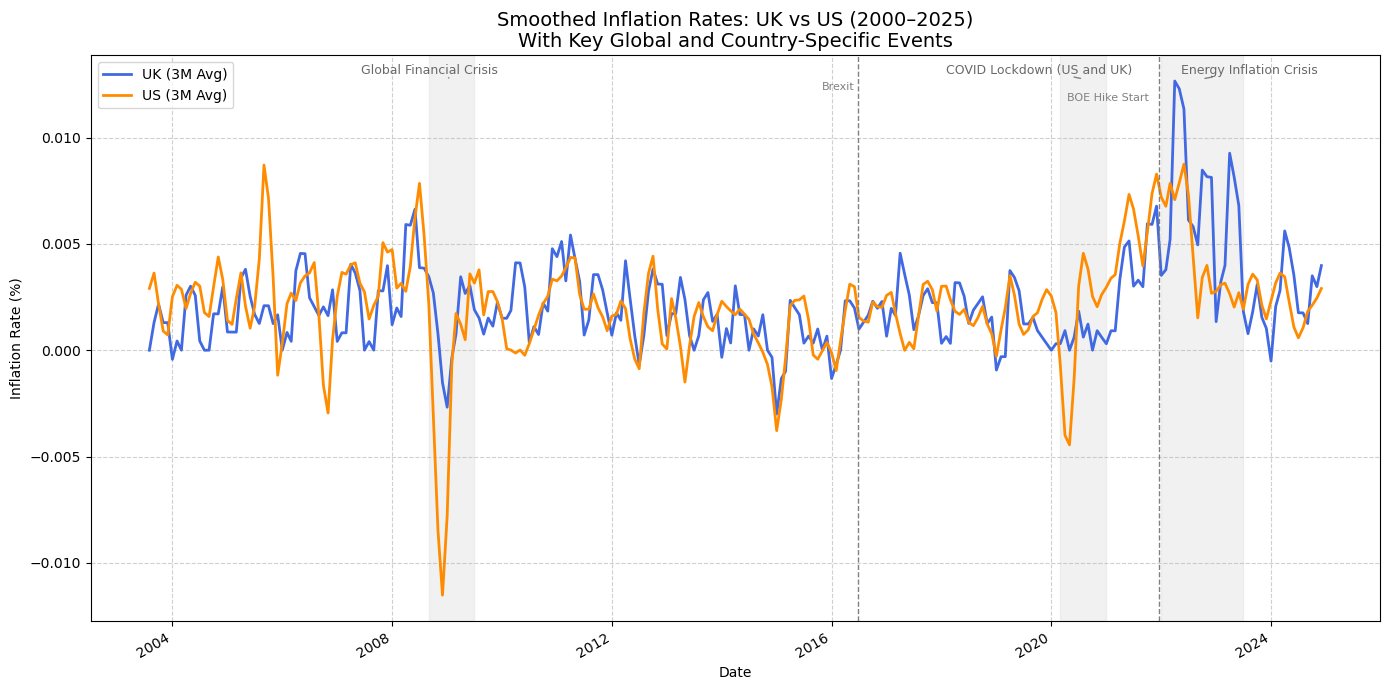

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1. Load and Prepare Data ===

uk_df = pd.read_csv('../data/UK_consolidated_df.csv')
us_df = pd.read_csv('../data/US_consolidated_df.csv')
uk_df['date'] = pd.to_datetime(uk_df['date'])
us_df['date'] = pd.to_datetime(us_df['date'])
uk_df = uk_df[uk_df['date'] > '2003-05-01'].reset_index(drop=True)


# Keep inflation and date only
uk_df = uk_df[['date', 'infl_rate']].rename(columns={'infl_rate': 'UK_inflation'})
us_df = us_df[['date', 'infl_rate']].rename(columns={'infl_rate': 'US_inflation'})

# Merge datasets
df = pd.merge(uk_df, us_df, on='date', how='inner')
df = df[df['date'] >= '2000-01-01'].reset_index(drop=True)

# Compute 3-month rolling averages
df['UK_rolling'] = df['UK_inflation'].rolling(window=3).mean()
df['US_rolling'] = df['US_inflation'].rolling(window=3).mean()

# === 2. Define Events and Crises Periods ===

shaded_periods = [
    ('2008-09-01', '2009-06-30', 'Global Financial Crisis'),
    ('2020-03-01', '2020-12-31', 'COVID Lockdown (US and UK)'),
    ('2022-01-01', '2023-06-30', 'Energy Inflation Crisis'),
]

highlight_events = [
    ('2016-06-23', 'Brexit'),
    ('2021-12-16', 'BOE Hike Start'),
]

# === 3. Plotting ===

fig, ax = plt.subplots(figsize=(14, 7))

# Plot rolling inflation
ax.plot(df['date'], df['UK_rolling'], color='royalblue', linestyle='-', linewidth=2, label='UK (3M Avg)')
ax.plot(df['date'], df['US_rolling'], color='darkorange', linestyle='-', linewidth=2, label='US (3M Avg)')

from adjustText import adjust_text

texts = []

# === Shaded crisis bands with label as text object ===
for start, end, label in shaded_periods:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightgray', alpha=0.3)
    midpoint = pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2
    t = ax.text(midpoint, ax.get_ylim()[1]*0.92, label, ha='center', fontsize=9, color='dimgray')
    texts.append(t)  # Add to adjustText list

# === Vertical highlight events with label ===
for date_str, label in highlight_events:
    date = pd.to_datetime(date_str)
    ax.axvline(date, color='gray', linestyle='--', linewidth=1)
    t = ax.text(date, ax.get_ylim()[1]*0.87, label, fontsize=8, color='gray', ha='right')
    texts.append(t)  # Add to same list

# === Adjust all labels to prevent overlap ===
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray'))




# Format axes and title
ax.set_title('Smoothed Inflation Rates: UK vs US (2000–2025)\nWith Key Global and Country-Specific Events', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Inflation Rate (%)')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
plt.tight_layout()

plt.show()




❓ **How do inflation rates compare across countries?**

 ✅ **Overall Comparison (UK vs US)**:
- Inflation rates in the **UK and US are broadly synchronized**, showing similar **ups and downs over time**.
- However, there are periods of **divergence in magnitude and timing**, particularly during certain **country-specific events**.


 📌 **Key Insights from the Plot**:

🔹 1. **Global Financial Crisis (2008–2009)**:
- **Both UK and US inflation fell sharply** after the crisis onset.
- The timing of the drop is nearly **simultaneous**, indicating **strong global synchronization**.

🔹 2. **Brexit (2016)**:
- A **UK-specific event**.
- No major inflation spike is seen in the UK immediately after the vote, but **US and UK paths diverge slightly** for a short period.
- Suggests **mild country-specific impact** on inflation.

🔹 3. **COVID Lockdown (2020)**:
- Inflation rates **fell in both countries**, reflecting **global demand shock**.
- Recovery is roughly synchronized, though the **UK shows a slightly sharper rebound**.

🔹 4. **Energy/Inflation Crisis (2022–2023)**:
- Both countries experienced **strong inflation spikes**, though the **UK peak is visibly higher** and more volatile.
- Likely driven by **different exposure to energy shocks**, Brexit aftermath, and supply chain recovery pace.
- Indicates **synchronized direction**, but **different scale** of impact.



🔍 Conclusion:

> UK and US inflation trends are **highly correlated during global events** (e.g. 2008, 2020, 2022), suggesting shared exposure to systemic shocks.  
> However, **national events** (e.g. Brexit, BOE rate changes) create **temporary divergences** in inflation dynamics.



Would you like:
- A short written report/summary based on this?
- To calculate and plot rolling correlation between the two inflation series?